In [67]:
#http://d2l.ai/chapter_multilayer-perceptrons/underfit-overfit.html
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l



max_degree = 20
n_train , n_test = 100 , 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5,1.2,3.4,5.6])
features = np.random.normal(size=(n_train + n_test, 1))
features[:10]


array([[ 0.86745371],
       [-1.186958  ],
       [ 1.41408713],
       [-1.08893196],
       [-1.96810446],
       [ 0.75550734],
       [ 1.6324968 ],
       [ 0.45724511],
       [ 1.72509083],
       [ 0.18464605]])

In [68]:
len(features)

200

In [69]:
np.random.shuffle(features)

poly_features = np.power(features,np.arange(max_degree).reshape(1,-1))

In [70]:
np.arange(max_degree).reshape(1,-1)

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19]])

In [71]:
poly_features

array([[ 1.00000000e+00,  1.77959838e-01,  3.16697039e-02, ...,
         1.80083541e-13,  3.20476378e-14,  5.70319242e-15],
       [ 1.00000000e+00, -1.25180732e+00,  1.56702157e+00, ...,
        -4.55131919e+01,  5.69737470e+01, -7.13201537e+01],
       [ 1.00000000e+00,  1.06397333e+00,  1.13203924e+00, ...,
         2.86960806e+00,  3.05318643e+00,  3.24850892e+00],
       ...,
       [ 1.00000000e+00, -6.28964059e-01,  3.95595787e-01, ...,
        -3.77258549e-04,  2.37282068e-04, -1.49241893e-04],
       [ 1.00000000e+00, -8.32309374e-01,  6.92738895e-01, ...,
        -4.41409184e-02,  3.67389001e-02, -3.05781310e-02],
       [ 1.00000000e+00, -1.66046426e-01,  2.75714157e-02, ...,
        -5.54500648e-14,  9.20728509e-15, -1.52883678e-15]])

In [72]:
len(poly_features)

200

In [73]:
poly_features[0]

array([1.00000000e+00, 1.77959838e-01, 3.16697039e-02, 5.63593537e-03,
       1.00297014e-03, 1.78488404e-04, 3.17637674e-05, 5.65267490e-06,
       1.00594911e-06, 1.79018540e-07, 3.18581104e-08, 5.66946416e-09,
       1.00893692e-09, 1.79550251e-10, 3.19527336e-11, 5.68630328e-12,
       1.01193361e-12, 1.80083541e-13, 3.20476378e-14, 5.70319242e-15])

In [74]:
##test on one sample to understand logic!
features[0]** 5

array([0.00017849])

In [75]:
len(features)


200

In [76]:
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# Shape of `labels`: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [77]:
# Convert from NumPy ndarrays to tensors
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 0.1780],
         [-1.2518]]),
 tensor([[ 1.0000e+00,  1.7796e-01,  1.5835e-02,  9.3932e-04,  4.1790e-05,
           1.4874e-06,  4.4116e-08,  1.1216e-09,  2.4949e-11,  4.9333e-13,
           8.7792e-15,  1.4203e-16,  2.1063e-18,  2.8834e-20,  3.6652e-22,
           4.3484e-24,  4.8365e-26,  5.0630e-28,  5.0056e-30,  4.6884e-32],
         [ 1.0000e+00, -1.2518e+00,  7.8351e-01, -3.2693e-01,  1.0231e-01,
          -2.5616e-02,  5.3443e-03, -9.5572e-04,  1.4955e-04, -2.0801e-05,
           2.6038e-06, -2.9632e-07,  3.0911e-08, -2.9765e-09,  2.6614e-10,
          -2.2211e-11,  1.7377e-12, -1.2796e-13,  8.8988e-15, -5.8630e-16]]),
 tensor([5.4233, 4.2088]))

In [78]:
def evaluate_loss(net, data_iter, loss):  #@save
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [79]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False)) #still a linear model!  
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[5.039578   1.207804   3.3098009  5.586483   0.15760426]]


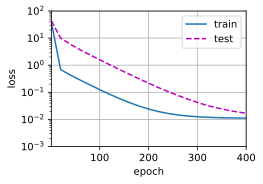

In [80]:
#not a bad fit with 5 features!
train(poly_features[:n_train, :5], poly_features[n_train:, :5],
      labels[:n_train], labels[n_train:])

weight: [[7.0410995 3.7441597]]


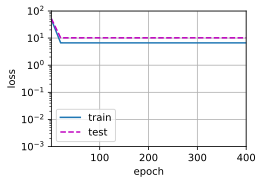

In [81]:
#Now lets look at an example of underfitting!
# Pick the first two dimensions, i.e., 1, x, from the polynomial features
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 5.040067    1.252491    3.3031266   5.2397094   0.19178264  1.3924767
  -0.018256    0.00769812  0.11213319  0.0397425   0.18250111  0.03127036
   0.01997042  0.09338864  0.15379532  0.10804318 -0.0512602  -0.16325106
  -0.09538557  0.2170126 ]]


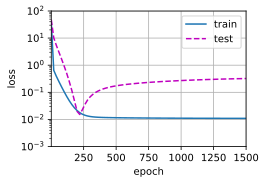

In [82]:
#An example of over fitting, using all powers!

train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

## Always choose an appropriately complex model and avoid using insufficient training data!